In [9]:
import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets

import matplotlib.pyplot as plt
import time
import copy
import dlc_practical_prologue as prologue
from BaseNet import *
from ConvNet1 import *

######################################################
### FRAMEWORK FOR INPUT AS ONE IMAGE OF 2 CHANNELS ###

# In this framework, the network is trained to directly predict if the first digit is less or equal to the second. It doesn't learn to recognize the digits.

nb_classes = 1
nb_input_channels = 2

mini_batch_size = 1000
nb_epochs = 50
eta = 0.001


# Network is a binary classifier: it simply predicts if the first digit is less than or equal to the second
def train_model_2C(model, train_input, train_target, optimizer, mini_batch_size=mini_batch_size,
                   criterion=torch.nn.BCEWithLogitsLoss(), nb_epochs=nb_epochs):
    train_target = train_target.type(torch.FloatTensor).view(-1, 1)
    print("train_target = ", train_target[:10])
    nb_samples = len(train_input)
    
    since = time.time()
    val_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for e in range(0, nb_epochs):
        
        for phase in ['train', 'val']:
            if phase == 'train': model.train()
            else: model.eval()
                
            running_loss = 0.0
            running_corrects = 0
            
            for b in range(0, train_input.size(0), mini_batch_size):
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    output = model(train_input.narrow(0, b, mini_batch_size))
                    print("output = ", output[0])
                    target = train_target.narrow(0, b, mini_batch_size)
                    print("target = ", target[:10])
                    
                    # the nn.BCEWithLogitsLoss expects
                    loss = criterion(output, target)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item() * train_input.size(0)
                #print("torch.sigmoid = ", torch.sigmoid(output))
                output_to_prediction = torch.ge(torch.sigmoid(output), 0.5)
                #print("output_to_prediction = ", output_to_prediction)
                running_corrects += torch.sum(output_to_prediction == target.type(torch.ByteTensor))       

            epoch_loss = running_loss / nb_samples
            epoch_acc = running_corrects.double() / nb_samples
            
            if (e % 100 == 99):
                print('phase: %s, epoch: %d, loss: %.5f, acc: %.4f' %
                      (phase, e+1, epoch_loss, epoch_acc))
                
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                
    time_elapsed = time.time() - since
    print('Training complete in %.0f min %.0f s' % (time_elapsed // 60, time_elapsed % 60))
    print('Best val acc: %.4f' % (best_acc))
    
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

def test_model_2C(model, test_input, test_target):
    model.eval()
    print("Model in training mode? ", model.training)

    # Number of pairs incorrectly identified
    test_output = model(test_input)
    output_to_prediction = torch.ge(torch.sigmoid(test_output), 0.5).flatten()
    
    nb_errors_pairs = torch.sum(output_to_prediction != test_target.type(torch.ByteTensor)).item()
    print("nb_errors_pairs = ", nb_errors_pairs)

In [10]:
train_input, train_target, train_classes, test_input, test_target, test_classes = \
    prologue.generate_pair_sets(nb=1000)

#model = BaseNet2C(nb_classes)
model = ConvNet1_2C(nb_classes)

optimizer = torch.optim.SGD(model.parameters(), lr=eta, momentum=0.95)
model, val_acc_history = train_model_2C(model, train_input, train_target, optimizer)


train_target =  tensor([[1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.]])
output =  tensor([5.8611], grad_fn=<SelectBackward>)
target =  tensor([[1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.]])
output =  tensor([-26.3650])
target =  tensor([[1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.]])
output =  tensor([-26.3650], grad_fn=<SelectBackward>)
target =  tensor([[1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.]])
output =  tensor([-2.4167])
target =  tensor([[1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.]])
output =  tensor([-2.4167], grad_fn=<SelectBackward>)
target =  tensor([[1

output =  tensor([1.2315])
target =  tensor([[1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.]])
output =  tensor([1.2315], grad_fn=<SelectBackward>)
target =  tensor([[1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.]])
output =  tensor([1.2643])
target =  tensor([[1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.]])
output =  tensor([1.2643], grad_fn=<SelectBackward>)
target =  tensor([[1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.]])
output =  tensor([1.6144])
target =  tensor([[1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.]])
output =  tensor([1.6144], grad_fn=<SelectBackward>)
targe

output =  tensor([3.3286])
target =  tensor([[1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.]])
output =  tensor([3.3286], grad_fn=<SelectBackward>)
target =  tensor([[1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.]])
output =  tensor([3.6281])
target =  tensor([[1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.]])
output =  tensor([3.6281], grad_fn=<SelectBackward>)
target =  tensor([[1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.]])
output =  tensor([3.7795])
target =  tensor([[1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.]])
output =  tensor([3.7795], grad_fn=<SelectBackward>)
targe

In [3]:
test_model_2C(model, test_input, test_target)

Model in training mode?  False
nb_errors_pairs =  268


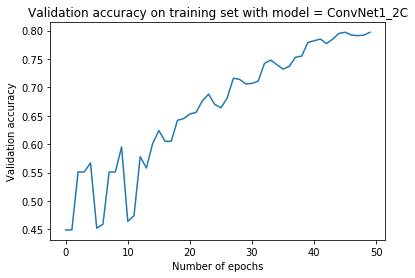

In [4]:
def plot_val_accuracy(model, val_acc_history):
    plt.plot(val_acc_history)
    plt.xlabel('Number of epochs')
    plt.ylabel('Validation accuracy')
    plt.title('Validation accuracy on training set with model = ' + model.name)
    plt.show()
    
plot_val_accuracy(model, val_acc_history)